# Błąd numeryczny

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import time
import sys
import os

# Dodanie folderu nadrzędnego do ścieżki systemowej
sys.path.append(os.path.abspath('..'))

from pipeline.flat import Flat

In [2]:
#@Tworzenie mieszkania

def create_flat(hx, ht):
    # Parametry geometryczne i temperaturowe takie same jak w Twoim eksperymencie
    flat = Flat(6, 10, 22, 22, 19, 22, -5, 22, 
                time_step=ht, space_step=hx) # Tu nadpisujemy kroki
    
    # Dodajemy te same obiekty co w eksperymencie
    flat.add_outer_object("south", 2.6, 4.8, "window")
    flat.add_outer_object("north", 4.6, 5.6, "door")
    flat.add_radiator("horizontal", 0.1, 1, 2.6, 9.8, 6885)
    flat.add_radiator("vertical", 0.1, 3, 3.8, 3.8, 500)
    flat.add_inner_object("horizontal", 4, 0.3, 0.2, 4, "wall")
    flat.add_inner_object("vertical", 4, 0.2, 0.2, 4, "wall")
    flat.add_inner_object("vertical", 4, 0.3, 1, 2, "door")
    
    return flat

--- Rozpoczynam analizę kroku przestrzennego (hx) ---
Dla hx=0.25m: Temp=21.4582C, Czas obl.=0.26s
Dla hx=0.2m: Temp=21.4237C, Czas obl.=0.45s
Dla hx=0.125m: Temp=21.3659C, Czas obl.=1.69s
Dla hx=0.1m: Temp=21.3484C, Czas obl.=3.87s

--- Rozpoczynam analizę kroku czasowego (ht) ---
Dla ht=1800s: Temp=21.4640C
Dla ht=300s: Temp=21.4304C
Dla ht=60s: Temp=21.4245C
Dla ht=30s: Temp=21.4237C
Dla ht=10s: Temp=21.4232C


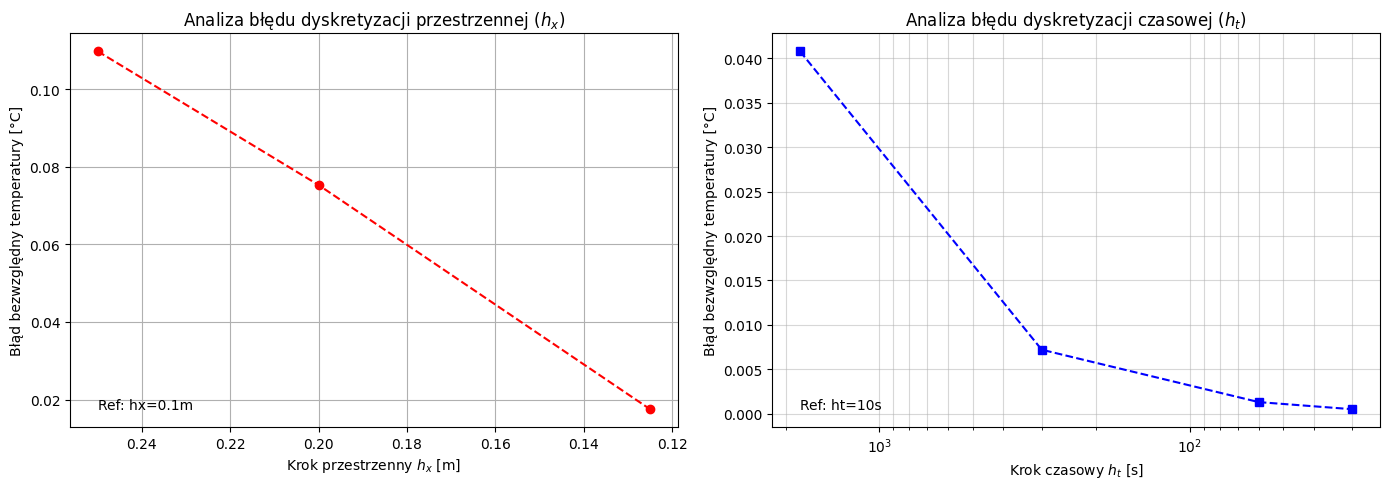

In [4]:
# --- CZĘŚĆ 1: Analiza kroku przestrzennego (hx) ---
print("--- Rozpoczynam analizę kroku przestrzennego (hx) ---")

# Lista testowanych kroków przestrzennych (w metrach)
# Uwaga: Im mniejszy krok, tym dłużej to trwa (zależność kwadratowa!)
hx_values = [0.25, 0.2, 0.125, 0.1] 
fixed_ht = 30 # Ustalony krok czasowy (np. 1 minuta)

results_hx = []
computation_times_hx = []

# Symulujemy 1 godzinę grzania dla każdego hx
for hx in hx_values:
    start_time = time.time()
    
    mieszkanie = create_flat(hx, fixed_ht)
    # Symulacja 1 godziny (heat_up przyjmuje godziny)
    _, avg_temp = mieszkanie.heat_up(1.0) 
    
    end_time = time.time()
    
    results_hx.append(avg_temp)
    computation_times_hx.append(end_time - start_time)
    print(f"Dla hx={hx}m: Temp={avg_temp:.4f}C, Czas obl.={end_time-start_time:.2f}s")

# Przyjmujemy wynik dla najmniejszego hx (0.1) jako "prawdę" (referencję)
reference_temp_hx = results_hx[-1]
errors_hx = [abs(temp - reference_temp_hx) for temp in results_hx[:-1]]

# --- CZĘŚĆ 2: Analiza kroku czasowego (ht) ---
print("\n--- Rozpoczynam analizę kroku czasowego (ht) ---")

# Lista testowanych kroków czasowych (w sekundach)
ht_values = [1800, 300, 60, 30, 10] # 30min, 5min, 1min, 30s, 10s
fixed_hx = 0.2 # Ustalony krok przestrzenny (dość dokładny, ale szybki)

results_ht = []

# Symulujemy 1 godzinę grzania dla każdego ht
for ht in ht_values:
    mieszkanie = create_flat(fixed_hx, ht)
    # Symulacja 1 godziny
    _, avg_temp = mieszkanie.heat_up(1.0)
    
    results_ht.append(avg_temp)
    print(f"Dla ht={ht}s: Temp={avg_temp:.4f}C")

# Przyjmujemy wynik dla najmniejszego ht (10s) jako "prawdę"
reference_temp_ht = results_ht[-1]
errors_ht = [abs(temp - reference_temp_ht) for temp in results_ht[:-1]]

# --- RYSOWANIE WYKRESÓW ---
fig, axs = plt.subplots(1, 2, figsize=(14, 5))

# Wykres błędu przestrzennego
axs[0].plot(hx_values[:-1], errors_hx, marker='o', linestyle='--', color='red')
axs[0].set_title('Analiza błędu dyskretyzacji przestrzennej ($h_x$)')
axs[0].set_xlabel('Krok przestrzenny $h_x$ [m]')
axs[0].set_ylabel('Błąd bezwzględny temperatury [°C]')
axs[0].invert_xaxis() # Oś od największego do najmniejszego kroku
axs[0].grid(True)
axs[0].text(hx_values[0], errors_hx[-1], f"Ref: hx={hx_values[-1]}m", fontsize=10)

# Wykres błędu czasowego
axs[1].plot(ht_values[:-1], errors_ht, marker='s', linestyle='--', color='blue')
axs[1].set_title('Analiza błędu dyskretyzacji czasowej ($h_t$)')
axs[1].set_xlabel('Krok czasowy $h_t$ [s]')
axs[1].set_ylabel('Błąd bezwzględny temperatury [°C]')
axs[1].set_xscale('log') # Skala logarytmiczna dla czasu jest często czytelniejsza
axs[1].invert_xaxis()
axs[1].grid(True, which="both", ls="-", alpha=0.5)
axs[1].text(ht_values[0], errors_ht[-1], f"Ref: ht={ht_values[-1]}s", fontsize=10)

plt.tight_layout()
plt.show()

Błąd dyskretyzacji przestrzennej spada o większą ilość temperatury wraz z zmniejszaniem go niż błąd dyskretyzacji czasowej. Biorąc to pod uwagę możemy wziąć w miarę duży krok czasowy (300 sekund) i najmniejszy krok przestrzenny (0.1 metra) dla symulacji o najlepszej dokładności, która wykonuje się w racjonalnym przedziale czasowym.